### Learning Human-Like Tonal Inflections for Humanoid Robotics  
Model architecture adpated from [https://github.com/adhishthite/sound-mnist](https://github.com/adhishthite/sound-mnist)

Mandarin Tone processing adapted from [https://github.com/alicex2020/Mandarin-Tone-Classification](https://github.com/alicex2020/Mandarin-Tone-Classification)

## **Import Packages**

In [29]:
import numpy as np 
import matplotlib
import math
import os
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import IPython.display as ipd
import keras
import librosa
import librosa.display
#!pip install natsort
from natsort import os_sorted
from pydub import AudioSegment

import warnings
warnings.filterwarnings('ignore')

## **Load Audio Data and Convert to MFCC's**
Human audio files sourced from Tone Perfect: [https://tone.lib.msu.edu/](https://tone.lib.msu.edu/)

In [86]:
file_path1 = 'C:/Users/charl/OneDrive/Desktop/CMU Sem. 01/ML/Project/Tone Perfect/tone_perfect'
file_path2 = 'C:/Users/charl/OneDrive/Desktop/CMU Sem. 01/ML/Project/Tone Perfect/tone_robot_new/NewRobotLong'

def mp3tomfcc(file_path, max_pad=60):
  """ 
  Human voice audio files are in .mp3 form 
  1. Load files with librosa
  2. Compute MFCC
  3. Pad MFCC  
  """  
  audio, sample_rate = librosa.core.load(file_path) # returns audio time series and sampling rate 
  mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=60)
  pad_width = max_pad - mfcc.shape[1]
  mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
  return mfcc

def wav2mfcc(file_path, fn, max_pad=60):
  """ 
  Robot audio files are in .wav form and require some data augmentation
  1. Load files with PyDub 
  2. Cut mic noise from first 0.05s
  3. Increase volume
  4. Add fade in/fade out
  5. Export as .wav files
  6. Load files with librosa
  7. Compute MFCC
  8. Pad MFCC
  """
  audio = AudioSegment.from_wav(file_path + '/' + fn)
  audio = audio[50:] # cut mic noise in first 0.05s
  audio += 15 # increase volume (dB)
  audio = audio.fade_in(250).fade_out(250) # 0.25s fade in and fade out
  
  fn_new = fn[:-4] + '_aug.wav' # edit filename and export
  audio.export(file_path + '/' + fn_new, 'wav')

  audio, sample_rate = librosa.core.load(file_path + '/' + fn_new) # load edited file with librosa
  audio = audio[::3] 
  audio = librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps = -20, bins_per_octave=12) # pitch down (12 steps per octive)
  
  mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=60)
  pad_width = max_pad - mfcc.shape[1]
  mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
  return mfcc

In [57]:
# load data from Tone Perfect
# 205 monosyllabic sounds in Mandarin Chinese * 4 tones * 6 speakers = 4,920 audio files (half of Tone Perfect database)
mfccs_human = []
counter = 0
for f in os.listdir(file_path1):
  if (f.endswith('.mp3')) and (counter < 4920):
    mfccs_human.append(mp3tomfcc(file_path1 + '/' + f, 60)) 
    counter += 1 

mfccs_h = np.asarray(mfccs_human)
print(f'mfccs_human.shape: {mfccs_h.shape}')

mfccs_human.shape: (4500, 60, 60)


In [87]:
# load data from robot
mfccs_robot = []
counter = 0  
for f in os_sorted(os.listdir(file_path2)): # natural sorting 
  if (f.endswith('.wav')) and (counter < 10000): # arbitrary large counter number if using whole dataset 
    mfccs_robot.append(wav2mfcc(file_path2, f, 60))
    counter += 1

mfccs_r = np.asarray(mfccs_robot)
print(f'mfccs_robot.shape: {mfccs_r.shape}')

mfccs_robot.shape: (1120, 60, 60)


In [88]:
# Save MFCC's 
np.save('mfccs/mfccs_half_human.npy', mfccs_human)
np.save('mfccs/mfccs_robot.npy', mfccs_robot)

In [87]:
# Load MFCC's from saved files
mfccs_human = np.load('mfccs/mfccs_half_human.npy').tolist()
mfccs_human = np.asarray(mfccs_human)

mfccs_robot = np.load('mfccs/mfccs_robot.npy').tolist()
mfccs_robot = np.asarray(mfccs_robot)

print(f'mfccs_human.shape: {mfccs_human.shape}')
print(f'mfccs_robot.shape: {mfccs_robot.shape}')

mfccs_human.shape: (4500, 60, 60)
mfccs_robot.shape: (1120, 60, 60)


## **Load Labels**

In [113]:
# Gather all labels for male and female speakers (1-4 for each of the four tones)
labels_human = []
counter = 0
for f in os.listdir(file_path1):
  if (f.endswith('.mp3')) and (counter < 4500):    
    label = f.split('_')[0][-1] # label is the last character before the first '_'
    labels_human.append(label)
    counter += 1

labels_human = np.array(labels_human)
print(f"# of files for Class 1: {(np.where(labels_human == '1')[0].size)}")
print(f"# of files for Class 2: {(np.where(labels_human == '2')[0].size)}")
print(f"# of files for Class 3: {(np.where(labels_human == '3')[0].size)}")
print(f"# of files for Class 4: {(np.where(labels_human == '4')[0].size)}")

labels_human = keras.utils.to_categorical(labels_human, num_classes=None) # one-hot encoding 

# of files for Class 1: 1128
# of files for Class 2: 1128
# of files for Class 3: 1122
# of files for Class 4: 1122


In [20]:
# Gather all labels for robot
labels_robot = []
counter = 0
labels_robot_arr = np.loadtxt("labels.csv", delimiter=",", dtype=str)
for i in range(0, labels_robot_arr.size):
    if labels_robot_arr[i] == 'HighLevel': # high level tone 
        labels_robot.append('1')
    elif labels_robot_arr[i] == 'Rise':
        labels_robot.append('2')
    elif labels_robot_arr[i] == 'Dip':
        labels_robot.append('3')
    elif labels_robot_arr[i] == 'Fall':
        labels_robot.append('4')
    else:
        labels_robot.append('5') # will remove and ignore any file not labeled as one of the above tones 

labels_robot = np.array(labels_robot)
print(f"# of files for Class 1: {(np.where(labels_robot == '1')[0].size)}")
print(f"# of files for Class 2: {(np.where(labels_robot == '2')[0].size)}")
print(f"# of files for Class 3: {(np.where(labels_robot == '3')[0].size)}")
print(f"# of files for Class 4: {(np.where(labels_robot == '4')[0].size)}")
print(f"# of files for Class 5: {(np.where(labels_robot == '5')[0].size)}")

labels_robot = keras.utils.to_categorical(labels_robot, num_classes=None) # one-hot encoding

# of files for Class 1: 280
# of files for Class 2: 280
# of files for Class 3: 280
# of files for Class 4: 280
# of files for Class 5: 0


In [21]:
print(f"Human Voice Label Vector Shape: {labels_human.shape}")
print(f"Human Voice Label Vector Preview:\n{labels_human[:5,:]}\n\n")

print(f"Robot Voice Label Vector Shape: {labels_robot.shape}")
print(f"Robot Voice Label Vector Preview:\n{labels_robot[:5,:]}")

Human Voice Label Vector Shape: (4500, 5)
Human Voice Label Vector Preview:
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


Robot Voice Label Vector Shape: (1120, 5)
Robot Voice Label Vector Preview:
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [22]:
# save labels 
np.save('labels/labels_half_human.npy', labels_human)
np.save('labels/labels_robot.npy', labels_robot)

In [86]:
# load labels 
labels_human = np.load('labels/labels_half_human.npy')
labels_robot = np.load('labels/labels_robot.npy')

## **Build Model**

In [32]:
import tensorflow as tf
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils import to_categorical

def get_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4)) # taking care of generalization 
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,  
                  optimizer=keras.optimizers.Adadelta(learning_rate=0.0001),
                  metrics=['accuracy'])
    return model

## **Training and Evaluation of Model Performance**

### Part I: Training and Testing on Robot Audio Signals

In [33]:
# define training and testing datasets
dim_1 = mfccs_robot.shape[1]
dim_2 = mfccs_robot.shape[2]
channels = 1
classes = 5

X = mfccs_robot
print(f'X.shape: {X.shape}')
X = X.reshape((mfccs_robot.shape[0], dim_1, dim_2, channels))
print(f'X.shape (reshaped): {X.shape}')
y = labels_robot
input_shape = (dim_1, dim_2, channels)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y, test_size=0.2, random_state=1)
print(f'X_train_r.shape: {X_train_r.shape}')

X.shape: (1120, 60, 60)
X.shape (reshaped): (1120, 60, 60, 1)
X_train_r.shape: (896, 60, 60, 1)


In [ ]:
# dealing with unequal class sizes 
"""
from sklearn.utils import class_weight
y_ints = [y.argmax() for y in y_train]

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_ints), y=y_ints)
class_weights_dict = dict(zip(np.unique(y_ints), class_weights))

history = model.fit(X_train, y_train, batch_size=20, epochs=15, verbose=1, validation_split=0.2, class_weight=class_weight_dict)
"""

In [34]:
model = get_cnn_model(input_shape, classes)
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 59, 59, 32)        160       
                                                                 
 batch_normalization_6 (Batc  (None, 59, 59, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 58, 58, 48)        6192      
                                                                 
 batch_normalization_7 (Batc  (None, 58, 58, 48)       192       
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (None, 57, 57, 120)       23160     
                                                                 
 batch_normalization_8 (Batc  (None, 57, 57, 120)     

In [35]:
# train on robot audio signals 
history_r = model.fit(X_train_r, y_train_r, batch_size=20, epochs=30, verbose=1, validation_split=0.2) 

Epoch 1/30
36/36 [==============================] - 7s 145ms/step - loss: 3.1086 - accuracy: 0.1816 - val_loss: 1.7265 - val_accuracy: 0.2056
Epoch 2/30
36/36 [==============================] - 6s 175ms/step - loss: 2.9925 - accuracy: 0.2165 - val_loss: 1.6935 - val_accuracy: 0.2056
Epoch 3/30
36/36 [==============================] - 6s 177ms/step - loss: 2.8303 - accuracy: 0.2277 - val_loss: 1.6826 - val_accuracy: 0.2000
Epoch 4/30
36/36 [==============================] - 6s 176ms/step - loss: 2.7946 - accuracy: 0.2207 - val_loss: 1.6541 - val_accuracy: 0.2389
Epoch 5/30
36/36 [==============================] - 9s 238ms/step - loss: 2.5904 - accuracy: 0.2640 - val_loss: 1.6121 - val_accuracy: 0.3000
Epoch 6/30
36/36 [==============================] - 8s 227ms/step - loss: 2.5781 - accuracy: 0.2430 - val_loss: 1.5615 - val_accuracy: 0.3167
Epoch 7/30
36/36 [==============================] - 8s 228ms/step - loss: 2.4648 - accuracy: 0.2696 - val_loss: 1.5041 - val_accuracy: 0.3278
Epoch 

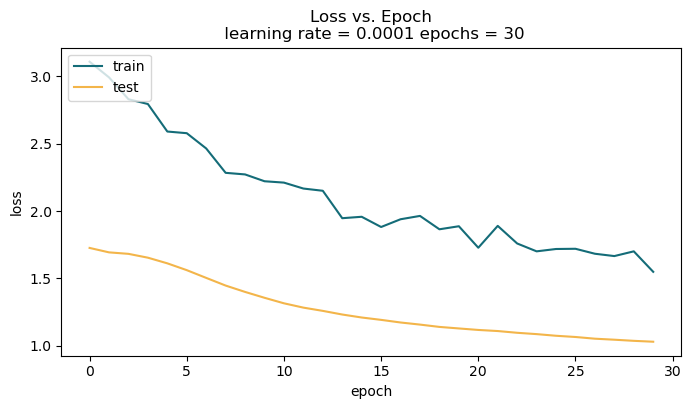

In [36]:
# loss vs. epoch
plt.figure(figsize=(8, 4))
plt.plot(history_r.history['loss'], color='#146C78')
plt.plot(history_r.history['val_loss'], color='#f3b54a')
plt.title('Loss vs. Epoch\n learning rate = 0.0001 epochs = 30')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
# evaluate model
test_metrics = model.evaluate(X_test_r, y_test_r, batch_size = 3, verbose = 1)

75/75 [==============================] - 1s 13ms/step - loss: 1.0587 - accuracy: 0.6205


In [38]:
# evaluate model on training
model.evaluate(X_train_r, y_train_r, batch_size = 3, verbose = 1)

299/299 [==============================] - 4s 12ms/step - loss: 1.0157 - accuracy: 0.6339


[1.0156733989715576, 0.6339285969734192]

In [39]:
# predicted and true labels 
import sklearn.metrics as metrics

y_pred = model.predict(X_test_r).ravel()
y_pred_ohe = model.predict(X_test_r)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)

y_true_labels = np.argmax(y_test_r, axis=1)

print(f'y_pred_labels.shape: {y_pred_labels.shape}')
print(f'y_true_labels.shape: {y_true_labels.shape}')

7/7 [==============================] - 0s 50ms/step
y_pred_labels.shape: (224,)
y_true_labels.shape: (224,)


7/7 [==============================] - 1s 75ms/step
Confusion matrix, without normalization
[[37 13 11  3]
 [12 37  8  0]
 [12  0 38  1]
 [10  0 15 27]]


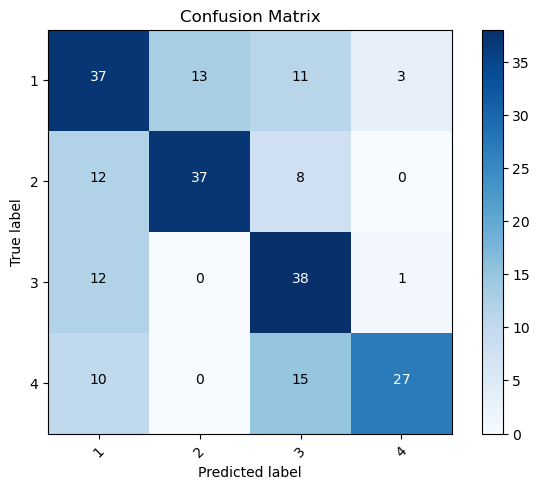

In [40]:
# consusion matrix 
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test_r).ravel()

y_true_labels = np.argmax(y_test_r, axis=1)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_true_labels, y_pred_labels)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cm, classes=[1, 2, 3, 4],
                      title='Confusion Matrix')

### Part II: Training on Human Audio Signals and Testing on Robot Audio Signals

In [43]:
# define training dataset
dim_1 = mfccs_human.shape[1]
dim_2 = mfccs_human.shape[2]
channels = 1
classes = 5

X_train_h = mfccs_human
print(f'X_train_h.shape: {X_train_h.shape}')
X_train_h = X_train_h.reshape((mfccs_human.shape[0], dim_1, dim_2, channels))
print(f'X_train_h.shape (reshaped): {X_train_h.shape}')
y_train_h = labels_human
input_shape = (dim_1, dim_2, channels)

print(f'y_train_h.shape: {y_train_h.shape}')

X_train_h.shape: (4500, 60, 60)
X_train_h.shape (reshaped): (4500, 60, 60, 1)
y_train_h.shape: (4500, 5)


In [44]:
# train on human audio signals 
history_h = model.fit(X_train_h, y_train_h, batch_size=20, epochs=30, verbose=1, validation_split=0.2) 

Epoch 1/30
180/180 [==============================] - 35s 192ms/step - loss: 2.3787 - accuracy: 0.2461 - val_loss: 1.4901 - val_accuracy: 0.3600
Epoch 2/30
180/180 [==============================] - 42s 234ms/step - loss: 2.2264 - accuracy: 0.2583 - val_loss: 1.4023 - val_accuracy: 0.3944
Epoch 3/30
180/180 [==============================] - 42s 232ms/step - loss: 2.0521 - accuracy: 0.2867 - val_loss: 1.3408 - val_accuracy: 0.4144
Epoch 4/30
180/180 [==============================] - 41s 230ms/step - loss: 1.9773 - accuracy: 0.2956 - val_loss: 1.2937 - val_accuracy: 0.4356
Epoch 5/30
180/180 [==============================] - 41s 229ms/step - loss: 1.8483 - accuracy: 0.3222 - val_loss: 1.2537 - val_accuracy: 0.4556
Epoch 6/30
180/180 [==============================] - 44s 246ms/step - loss: 1.7797 - accuracy: 0.3297 - val_loss: 1.2217 - val_accuracy: 0.4822
Epoch 7/30
180/180 [==============================] - 504s 3s/step - loss: 1.7422 - accuracy: 0.3439 - val_loss: 1.1925 - val_accu

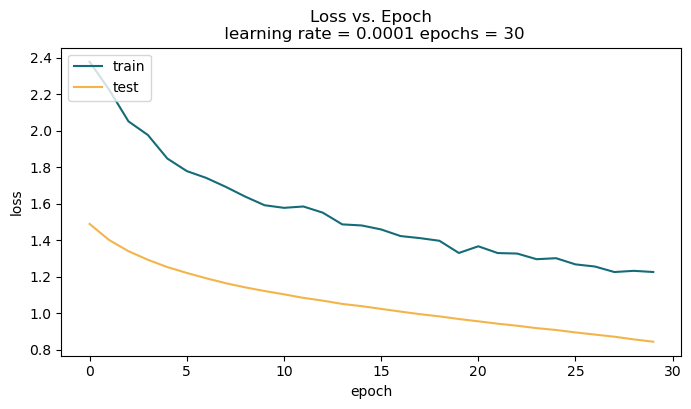

In [45]:
# loss vs. epoch
plt.figure(figsize=(8, 4))
plt.plot(history_h.history['loss'], color='#146C78')
plt.plot(history_h.history['val_loss'], color='#f3b54a')
plt.title('Loss vs. Epoch\n learning rate = 0.0001 epochs = 30')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [46]:
# testing on full robot audio dataset   
dim_1 = mfccs_robot.shape[1]
dim_2 = mfccs_robot.shape[2]
channels = 1
classes = 5

X_test_full_r = mfccs_robot
print(f'X_test.shape: {X_test_full_r.shape}')
X_test_full_r = X_test_full_r.reshape((mfccs_robot.shape[0], dim_1, dim_2, channels))
print(f'X_test.shape (rehsaped): {X_test_full_r.shape}')
y_test_full_r = labels_robot

print(f'y_test.shape: {y_test_full_r.shape}')

X_test.shape: (1120, 60, 60)
X_test.shape (rehsaped): (1120, 60, 60, 1)
y_test.shape: (1120, 5)


In [47]:
# evaluate model
test_metrics = model.evaluate(X_test_full_r, y_test_full_r, batch_size = 3, verbose = 1)

374/374 [==============================] - 5s 14ms/step - loss: 1.4340 - accuracy: 0.3152


In [48]:
# evaluate model on training
model.evaluate(X_train_h, y_train_h, batch_size = 3, verbose = 1)

1500/1500 [==============================] - 23s 15ms/step - loss: 0.8457 - accuracy: 0.7324


[0.8456857204437256, 0.7324444651603699]

In [49]:
# predicted and true labels 
y_pred = model.predict(X_test_full_r).ravel()
y_pred_ohe = model.predict(X_test_full_r)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)

y_true_labels = np.argmax(y_test_full_r, axis=1)

print(f'y_pred_labels.shape: {y_pred_labels.shape}')
print(f'y_true_labels.shape: {y_true_labels.shape}')

#confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
#print(confusion_matrix)

35/35 [==============================] - 2s 44ms/step
y_pred_labels.shape: (1120,)
y_true_labels.shape: (1120,)


In [50]:
# save labels
np.save('labels/y_pred_labels.npy', y_pred_labels)
np.save('labels/y_true_labels.npy', y_true_labels)

In [84]:
# finding high probability classes
print(f'Sum of first row probabilities: {np.sum(y_pred_ohe[0,:])}')
print(f'Sum of second row probabilities: {np.sum(y_pred_ohe[1,:])}')
print(f'y_pred.shape: {y_pred_ohe.shape}')

#y_true_labels[np.where(y_pred_ohe > 0.98)[0]] == y_pred_labels[np.where(y_pred_ohe > 0.98)[0]]
#np.where(y_pred_ohe > 0.95)[0]
#np.where(y_pred_labels != y_true_labels)

Sum of first row probabilities: 0.9999999403953552
Sum of second row probabilities: 1.0000001192092896
y_pred.shape: (1120, 5)


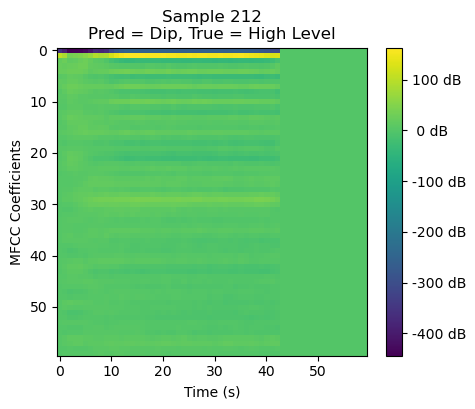

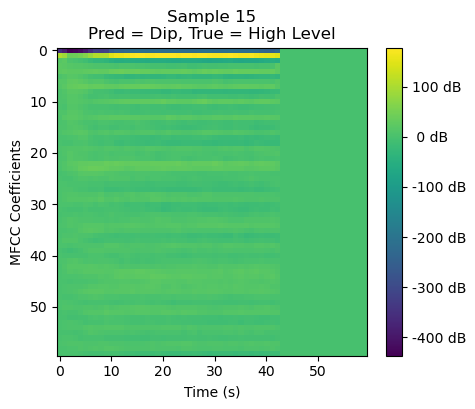

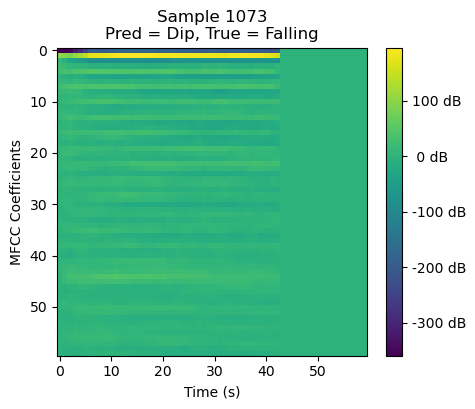

In [83]:
# plot incorrectly classified tones
plt.figure(figsize=(5, 4))
plt.imshow(mfccs_robot[212,:,:], aspect='auto')
plt.title('Sample 212\nPred = Dip, True = High Level')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients') 
plt.colorbar(format="%2.f dB")
plt.show()

plt.figure(figsize=(5, 4))
plt.imshow(mfccs_robot[15,:,:], aspect='auto')
plt.title('Sample 15\nPred = Dip, True = High Level')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients') 
plt.colorbar(format="%2.f dB")
plt.show()

plt.figure(figsize=(5, 4))
plt.imshow(mfccs_robot[1073,:,:], aspect='auto')
plt.title('Sample 1073\nPred = Dip, True = Falling')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients') 
plt.colorbar(format="%2.f dB")
plt.show()

35/35 [==============================] - 2s 52ms/step
Confusion matrix, without normalization
[[ 32  25 223   0]
 [ 15  43 222   0]
 [  1   1 278   0]
 [  7   0 273   0]]


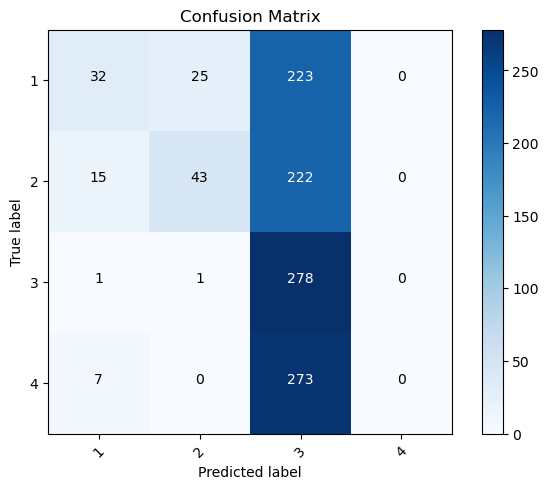

In [54]:
# confusion matrix
y_pred = model.predict(X_test_full_r).ravel()

y_true_labels = np.argmax(y_test_full_r, axis=1)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_true_labels, y_pred_labels)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cm, classes=[1, 2, 3, 4],
                      title='Confusion Matrix')